# MTG metagame
***
Extract the counts of the most played decks lately in the different formats of Magic: The Gathering according to data from registered tournaments.

*The information presented about Magic: The Gathering, both literal and graphical, is copyrighted by Wizards of the Coast. This notebook is not produced, endorsed, supported, or affiliated with Wizards of the Coast.*

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re

The different formats follow the 2-letter code (with the exception of EDH):

In [2]:
formats = {'Vintage': 'VI', 'Legacy': 'LE', 'Modern': 'MO', 'Pioneer': 'PI', 'Commander': 'EDH'}
mtg_format = formats['Modern']

**Note:** each format has it's own metagame and will be listed by different time frames.

## Data scraping

In [3]:
page = requests.get('https://www.mtgtop8.com/format?f='+mtg_format)
soup = BeautifulSoup(page.content, 'lxml')

The relevant information are table rows of class `'hover_tr'`
![img/rows.png](img/rows.png)

In [4]:
rows = soup.find_all('tr', class_=['hover_tr', 'chosen_tr'])
# For some reason, a deck might be selected by default, putting it under the class 'chosen_tr' instead

In [5]:
print([repr(row.get_text()) for row in rows[:3]])

["'\\nRed Deck Wins\\n154\\n10 %\\n\\n\\n'", '"\\nDeath\'s Shadow\\n99\\n7 %\\n\\n\\n"', "'\\nEldrazi Aggro\\n93\\n6 %\\n\\n\\n'"]


In [6]:
clean_rows1 = []
for row in rows:
    clean_rows1.append(row.get_text().split('\n'))

In [7]:
print(clean_rows1[:3])

[['', 'Red Deck Wins', '154', '10 %', '', '', ''], ['', "Death's Shadow", '99', '7 %', '', '', ''], ['', 'Eldrazi Aggro', '93', '6 %', '', '', '']]


In [8]:
clean_rows2 = []
for row in clean_rows1:
    clean_rows2.append([s for s in row if s])

In [9]:
print(clean_rows2[:3])

[['Red Deck Wins', '154', '10 %'], ["Death's Shadow", '99', '7 %'], ['Eldrazi Aggro', '93', '6 %']]


Now we want to find out the number of decks of each **strategy** to know how many rows we read.

![img/strat.png](img/strat.png)

By counting manually, we find out that the number of decks is the number indicated by the attribute `'rowspan'` minus one.

In [11]:
strategy = [item for item in soup.find_all('td') if item.has_attr('rowspan')]

In [12]:
strat_dict = {}
for strat in strategy:
    strat_dict[re.sub('[^a-zA-Z]+', '', strat.get_text())] = int(strat.attrs['rowspan']) - 1
    
print(strat_dict)

{'Aggro': 31, 'Control': 20, 'Combo': 20}


In [13]:
num_of_decks = sum(strat_dict.values())
print(num_of_decks)

71


In [14]:
clean_rows2 = clean_rows2[:num_of_decks]

In [15]:
columns = ['Archetype', 'Decks', 'Meta share']
df = pd.DataFrame(clean_rows2, columns=columns)
df.head()

,Archetype,Decks,Meta share
0,Red Deck Wins,154,10 %
1,Death's Shadow,99,7 %
2,Eldrazi Aggro,93,6 %
3,Jund,86,6 %
4,Humans,42,3 %


Since the meta share is a derived information based on the number of decks of each archetype, we can drop that column.

In [16]:
df = df.drop('Meta share', axis=1)

Now we add the strategy of each deck (as in Aggro, Control or Combo).

In [17]:
df['Strategy'] = None

In [18]:
i = 0
for k,v in strat_dict.items():
    for j in range(v):
        df['Strategy'].iloc[i] = k
        i += 1

And change the `'Deck'` column dtype to numeric so we can perform calculations. Also, sort the data by the decks count.

In [19]:
df['Decks'] = pd.to_numeric(df['Decks'])
df = df.sort_values(by='Decks', ascending=False).reset_index(drop=True)

## Data analysis

In [20]:
df_by_strat = df.groupby(['Strategy']).sum()
df_by_strat

,Decks
Strategy,
Aggro,687
Combo,360
Control,424


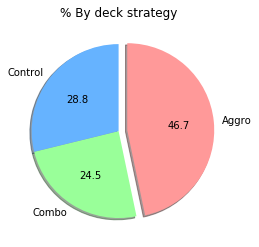

In [21]:
sizes = df_by_strat['Decks']
explode = (0.1, 0, 0)
labels = df_by_strat.index
colors = ['#ff9999', '#99ff99', '#66b3ff']

plt.pie(sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct='%1.1f',
        shadow=True,
        counterclock=False,
        startangle=90)
plt.title('% By deck strategy')
plt.show()

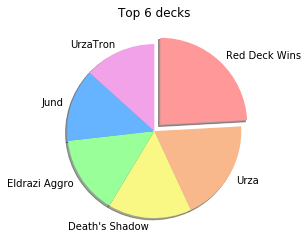

In [24]:
sizes = df['Decks'].head(6)
explode = (0.1, 0, 0, 0, 0, 0)
labels = df['Archetype'].head(6)
colors = ['#ff9999', '#f8b88b', '#faf884', '#99ff99', '#66b3ff', '#f2a2e8']

plt.pie(sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        shadow=True,
        counterclock=False,
        startangle=90)
plt.title('Top 6 decks')
plt.show()